# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import FileLink
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.stats import uniform, randint
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict, 
    ShuffleSplit, 
    train_test_split,
)
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphSAGE, SAGEConv, BatchNorm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import optuna
import copy

# Download the Data

In [2]:
supercond_df = pd.read_csv('/home/ckasemtantikul/cleaned_supercond_df.csv')
final_design_matrix_supercond = pd.read_csv('/home/ckasemtantikul/final_design_matrix_supercond.csv')
df = pd.merge(supercond_df, final_design_matrix_supercond, left_index=True, right_index=True, how='left')
df = df.dropna()

In [3]:
X = df.drop(['chemical_formula','Tc','composition','elements','Category','num_elements','stoichiometry'], axis=1)
y = df[['Tc']]
display(X)
display(y)

,Average AtomicRadius,Average AtomicVolume,Average AtomicWeight,Average BoilingT,Average CovalentRadius,Average Density,Average ElectronAffinity,Average Electronegativity,Average FirstIonizationEnergy,Average HeatCapacityMass,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,1.097143,10637.113673,57.873967,1542.185714,115.885714,2974.616571,110.470357,2.546929,10.471085,0.635479,...,95.178571,95.061224,12.0,1.857143,2.285714,1.692857,0.000000,False,0.803211,0.165284
1,1.093929,10636.906970,56.808817,1531.728571,115.457143,2955.759429,110.279214,2.548214,10.481439,0.637664,...,95.092857,94.963265,12.0,1.857143,2.285714,1.692857,0.000000,False,0.787757,0.164994
2,1.047143,10635.250819,67.135606,1514.857143,110.800000,3905.930857,110.741429,2.589143,10.429637,0.625000,...,95.428571,95.346939,12.0,1.857143,2.285714,1.685714,3.600000,False,0.803211,0.155938
3,1.094643,10637.075533,56.330499,1519.428571,115.571429,2899.123714,109.180857,2.544571,10.475865,0.639450,...,95.092857,94.963265,12.0,1.864286,2.285714,1.628571,0.000000,False,0.787757,0.165653
4,1.094286,10637.036937,56.424486,1517.542857,115.401429,2926.630857,109.875429,2.546757,10.480881,0.638606,...,95.320000,95.222857,12.0,1.858571,2.285714,1.675714,0.000000,False,0.787757,0.165292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,1.196667,26.523951,80.111022,1944.373667,130.100000,5445.850000,74.800000,1.962833,9.149645,0.550150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.600000,4.666667,False,0.348856,0.053305
8834,1.203333,26.765795,79.993582,1904.340333,130.500000,5330.216667,76.466667,1.961833,9.103004,0.550483,...,78.466667,77.022222,2.0,2.000000,2.183333,0.566667,4.666667,False,0.348856,0.053562
8835,1.210000,27.007639,79.876142,1864.307000,130.900000,5214.583333,78.133333,1.960833,9.056364,0.550817,...,78.466667,77.022222,2.0,2.000000,2.183333,0.533333,4.666667,False,0.348856,0.053819
8836,1.216667,27.249483,79.758702,1824.273667,131.300000,5098.950000,79.800000,1.959833,9.009724,0.551150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.500000,4.666667,False,0.348856,0.054076


,Tc
0,30.00
1,39.00
2,71.90
3,21.00
4,12.00
...,...
8833,4.09
8834,4.85
8835,4.48
8836,5.87


# Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

# Apply normalization to X

In [5]:
# Normalize train

scaler = StandardScaler()
scaler.fit(X_train)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_train_X = scaler.transform(X_train)

column_names = X_train.columns
norm_train_X = pd.DataFrame(scaler.transform(X_train), columns=column_names)

scaler = StandardScaler()
scaler.fit(X_test)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_test_X = scaler.transform(X_test)

column_names = X_train.columns
norm_test_X = pd.DataFrame(scaler.transform(X_test), columns=column_names)

# Convert Dataframe to Numpy array

In [6]:
norm_train_X = norm_train_X.to_numpy() if hasattr(norm_train_X, 'to_numpy') else norm_train_X
norm_test_X = norm_test_X.to_numpy() if hasattr(norm_test_X, 'to_numpy') else norm_test_X
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Define GNN model and parameters

In [7]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_layers, dropout_rate, conv_type='GCN'):
        super(GNNModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        if conv_type == 'GCN':
            self.convs.append(GCNConv(num_features, hidden_channels))
            self.bns.append(BatchNorm(hidden_channels))
            for _ in range(num_layers - 1):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
                self.bns.append(BatchNorm(hidden_channels))
        elif conv_type == 'GAT':
            self.convs.append(GATConv(num_features, hidden_channels // 8, heads=8, concat=True))
            self.bns.append(BatchNorm(hidden_channels))
            for _ in range(num_layers - 1):
                self.convs.append(GATConv(hidden_channels, hidden_channels // 8, heads=8, concat=True))
                self.bns.append(BatchNorm(hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, 1)
        self.dropout_rate = dropout_rate
        self.apply(self._init_weights)

    def forward(self, x, edge_index):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)
        return x

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a KNN graph for your training data
k = 10
knn_graph_train = kneighbors_graph(norm_train_X, k, mode='connectivity', include_self=True)
edge_index_train = torch.tensor(np.array(knn_graph_train.nonzero()), dtype=torch.long).to(device)

knn_graph_test = kneighbors_graph(norm_test_X, k, mode='connectivity', include_self=True)
edge_index_test = torch.tensor(np.array(knn_graph_test.nonzero()), dtype=torch.long).to(device)

# Convert your features and labels to tensors
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1).to(device)
x_test = torch.tensor(norm_test_X, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1).to(device)

# Create PyTorch Geometric data objects
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test)

# Create data loaders
train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data], batch_size=1)

# Hyperparameter tuning with optuna

# (Skip this part if already tuned)

In [9]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 100, 180)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.4)
    conv_type = trial.suggest_categorical('conv_type', ['GCN'])

    # Ensure hidden_channels is divisible by heads for GATConv
    heads = 8
    if conv_type == 'GAT':
        if hidden_channels % heads != 0:
            hidden_channels -= hidden_channels % heads

    model = GNNModel(num_features=norm_train_X.shape[1], hidden_channels=hidden_channels, num_layers=num_layers, dropout_rate=dropout_rate, conv_type=conv_type).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = torch.nn.MSELoss()

    model.train()
    for epoch in range(100):  # Increased number of epochs
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index)
            batch_loss = mean_squared_error(batch.y.cpu(), pred.cpu())
            val_loss += batch_loss
        val_loss /= len(test_loader)

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)  # Increase number of trials


[I 2024-06-06 22:53:15,519] A new study created in memory with name: no-name-b6b81393-2b0f-492a-92a0-638fd9c27ea4
[I 2024-06-06 22:53:16,494] Trial 0 finished with value: 819.3798217773438 and parameters: {'hidden_channels': 105, 'learning_rate': 0.00025903838591725086, 'weight_decay': 3.406643945299402e-05, 'num_layers': 2, 'dropout_rate': 0.22492678162687677, 'conv_type': 'GCN'}. Best is trial 0 with value: 819.3798217773438.
[I 2024-06-06 22:53:17,483] Trial 1 finished with value: 692.7726440429688 and parameters: {'hidden_channels': 133, 'learning_rate': 0.0005961969228667792, 'weight_decay': 0.0003735877435611416, 'num_layers': 3, 'dropout_rate': 0.1587830076311434, 'conv_type': 'GCN'}. Best is trial 1 with value: 692.7726440429688.
[I 2024-06-06 22:53:18,695] Trial 2 finished with value: 626.9869384765625 and parameters: {'hidden_channels': 178, 'learning_rate': 0.0006428480984551255, 'weight_decay': 4.543530261550687e-05, 'num_layers': 3, 'dropout_rate': 0.05954470017271476, 'co

[I 2024-06-06 22:53:40,120] Trial 26 finished with value: 255.30357360839844 and parameters: {'hidden_channels': 118, 'learning_rate': 0.009942926080319258, 'weight_decay': 7.907166152280369e-05, 'num_layers': 3, 'dropout_rate': 0.2140014172253853, 'conv_type': 'GCN'}. Best is trial 18 with value: 240.30946350097656.
[I 2024-06-06 22:53:40,935] Trial 27 finished with value: 257.61767578125 and parameters: {'hidden_channels': 100, 'learning_rate': 0.006434306293141004, 'weight_decay': 1.4130216195491985e-05, 'num_layers': 3, 'dropout_rate': 0.35728241568650243, 'conv_type': 'GCN'}. Best is trial 18 with value: 240.30946350097656.
[I 2024-06-06 22:53:41,802] Trial 28 finished with value: 400.26287841796875 and parameters: {'hidden_channels': 111, 'learning_rate': 0.0018528777236199757, 'weight_decay': 2.3275983724841603e-05, 'num_layers': 3, 'dropout_rate': 0.24764279041578305, 'conv_type': 'GCN'}. Best is trial 18 with value: 240.30946350097656.
[I 2024-06-06 22:53:42,407] Trial 29 fini

[I 2024-06-06 22:54:02,682] Trial 52 finished with value: 207.2661895751953 and parameters: {'hidden_channels': 178, 'learning_rate': 0.0030095239392975925, 'weight_decay': 0.0007003263891423066, 'num_layers': 2, 'dropout_rate': 0.12482514851816134, 'conv_type': 'GCN'}. Best is trial 50 with value: 204.81008911132812.
[I 2024-06-06 22:54:03,540] Trial 53 finished with value: 199.7734375 and parameters: {'hidden_channels': 177, 'learning_rate': 0.002981661990468425, 'weight_decay': 0.000688616876309508, 'num_layers': 2, 'dropout_rate': 0.10648897655269776, 'conv_type': 'GCN'}. Best is trial 53 with value: 199.7734375.
[I 2024-06-06 22:54:04,409] Trial 54 finished with value: 202.53968811035156 and parameters: {'hidden_channels': 179, 'learning_rate': 0.0031664677051888093, 'weight_decay': 0.0007303520863505254, 'num_layers': 2, 'dropout_rate': 0.0761370866565397, 'conv_type': 'GCN'}. Best is trial 53 with value: 199.7734375.
[I 2024-06-06 22:54:05,259] Trial 55 finished with value: 211.

[I 2024-06-06 22:54:24,749] Trial 78 finished with value: 240.30691528320312 and parameters: {'hidden_channels': 172, 'learning_rate': 0.004481933214829875, 'weight_decay': 0.0003552277197547759, 'num_layers': 2, 'dropout_rate': 0.09386693976196733, 'conv_type': 'GCN'}. Best is trial 62 with value: 198.09890747070312.
[I 2024-06-06 22:54:25,635] Trial 79 finished with value: 205.84962463378906 and parameters: {'hidden_channels': 180, 'learning_rate': 0.005405012139296902, 'weight_decay': 0.00044168804663403727, 'num_layers': 2, 'dropout_rate': 0.2376033783104485, 'conv_type': 'GCN'}. Best is trial 62 with value: 198.09890747070312.
[I 2024-06-06 22:54:26,445] Trial 80 finished with value: 211.7288818359375 and parameters: {'hidden_channels': 162, 'learning_rate': 0.005008896804093005, 'weight_decay': 0.00017201374436756465, 'num_layers': 2, 'dropout_rate': 0.20634982860710988, 'conv_type': 'GCN'}. Best is trial 62 with value: 198.09890747070312.
[I 2024-06-06 22:54:27,274] Trial 81 fin

[I 2024-06-06 22:54:46,834] Trial 104 finished with value: 214.0819091796875 and parameters: {'hidden_channels': 176, 'learning_rate': 0.008107464963147478, 'weight_decay': 0.00029141147293486666, 'num_layers': 2, 'dropout_rate': 0.11704565892874393, 'conv_type': 'GCN'}. Best is trial 96 with value: 194.92086791992188.
[I 2024-06-06 22:54:47,667] Trial 105 finished with value: 195.68838500976562 and parameters: {'hidden_channels': 170, 'learning_rate': 0.005546661860539007, 'weight_decay': 0.0005050553290113105, 'num_layers': 2, 'dropout_rate': 0.017701790796745418, 'conv_type': 'GCN'}. Best is trial 96 with value: 194.92086791992188.
[I 2024-06-06 22:54:48,506] Trial 106 finished with value: 195.83314514160156 and parameters: {'hidden_channels': 170, 'learning_rate': 0.005552766881203796, 'weight_decay': 0.0005797064071521053, 'num_layers': 2, 'dropout_rate': 0.016941890499139346, 'conv_type': 'GCN'}. Best is trial 96 with value: 194.92086791992188.
[I 2024-06-06 22:54:49,344] Trial 1

[I 2024-06-06 22:55:08,728] Trial 130 finished with value: 427.8057556152344 and parameters: {'hidden_channels': 180, 'learning_rate': 0.0010156798629454972, 'weight_decay': 0.00047541892996298387, 'num_layers': 2, 'dropout_rate': 0.010230003614350983, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:09,586] Trial 131 finished with value: 196.82737731933594 and parameters: {'hidden_channels': 178, 'learning_rate': 0.007696048146666588, 'weight_decay': 0.00044878193669838713, 'num_layers': 2, 'dropout_rate': 0.04155823505731669, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:10,443] Trial 132 finished with value: 210.44573974609375 and parameters: {'hidden_channels': 178, 'learning_rate': 0.0069537915032441035, 'weight_decay': 0.00041331084125388064, 'num_layers': 2, 'dropout_rate': 0.04014747166493441, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:11,273] T

[I 2024-06-06 22:55:30,602] Trial 156 finished with value: 216.02145385742188 and parameters: {'hidden_channels': 180, 'learning_rate': 0.006666745802511463, 'weight_decay': 0.00041904382117628145, 'num_layers': 2, 'dropout_rate': 0.072710921723617, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:31,465] Trial 157 finished with value: 225.0418243408203 and parameters: {'hidden_channels': 177, 'learning_rate': 0.005437216018700825, 'weight_decay': 0.000637412230475293, 'num_layers': 2, 'dropout_rate': 0.03057715602379721, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:32,188] Trial 158 finished with value: 197.82168579101562 and parameters: {'hidden_channels': 140, 'learning_rate': 0.00923731502026478, 'weight_decay': 0.0004886551953496401, 'num_layers': 2, 'dropout_rate': 0.016591775127571033, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:32,910] Trial 159

[I 2024-06-06 22:55:51,419] Trial 182 finished with value: 242.3081817626953 and parameters: {'hidden_channels': 155, 'learning_rate': 0.008409179579316734, 'weight_decay': 0.00042570052255854103, 'num_layers': 2, 'dropout_rate': 0.03866427867676175, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:52,272] Trial 183 finished with value: 216.67408752441406 and parameters: {'hidden_channels': 175, 'learning_rate': 0.006913934447908854, 'weight_decay': 1.2200222807699533e-05, 'num_layers': 2, 'dropout_rate': 0.023659822711868467, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:53,106] Trial 184 finished with value: 225.70416259765625 and parameters: {'hidden_channels': 176, 'learning_rate': 0.009693806736654903, 'weight_decay': 0.0003503470626636533, 'num_layers': 2, 'dropout_rate': 0.04650110072715833, 'conv_type': 'GCN'}. Best is trial 110 with value: 193.09817504882812.
[I 2024-06-06 22:55:53,941] Tria

# Training the final model with best hyperparameters

In [10]:
# Get the best hyperparameters

# best_params = study.best_params
# print(best_params)

best_params = {'hidden_channels': 123, 'learning_rate': 0.0038180944100928314, 'weight_decay': 6.336991086718003e-05, 'num_layers': 2, 'dropout_rate': 0.04463210774404339, 'conv_type': 'GCN'}

# Initialize the model with the best hyperparameters found
model = GNNModel(num_features=norm_train_X.shape[1], hidden_channels=best_params['hidden_channels'], num_layers=best_params['num_layers'], dropout_rate=best_params['dropout_rate'], conv_type=best_params['conv_type']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = torch.nn.MSELoss()

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
best_model = None
epochs_no_improve = 0

# Training loop with early stopping and more epochs
train_losses = []
val_losses = []

model.train()
for epoch in range(4000):  # Increased number of epochs
    running_train_loss = 0.0
    running_val_loss = 0.0

    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            val_loss = criterion(out, batch.y)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(test_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Save the model
torch.save(model.state_dict(), 'gnn_model.pth')

# Load hte model
model = best_model

Epoch 100, Train Loss: 104.1448, Validation Loss: 214.7169
Early stopping at epoch 108


# Model Prediction

In [11]:
# Predictions
model.eval()
with torch.no_grad():
    pred_train_y = model(x_train, edge_index_train).cpu().numpy()
    pred_test_y = model(x_test, edge_index_test).cpu().numpy()

# Model Evaluation

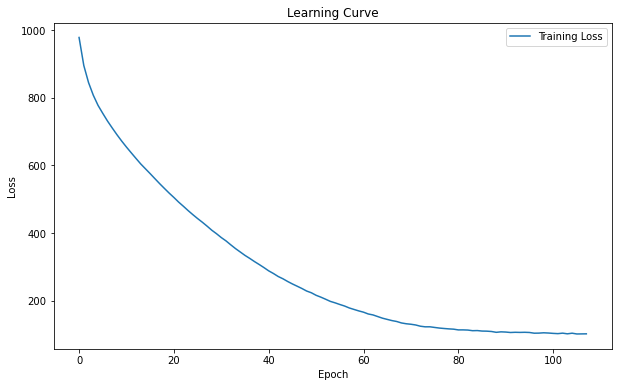

In [12]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

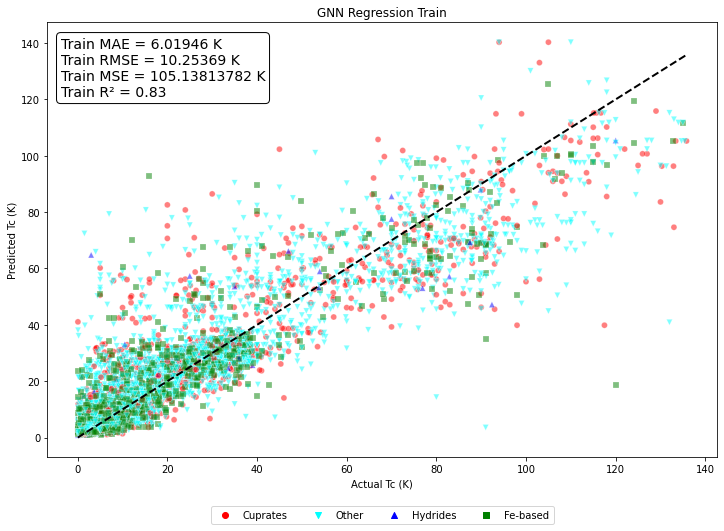

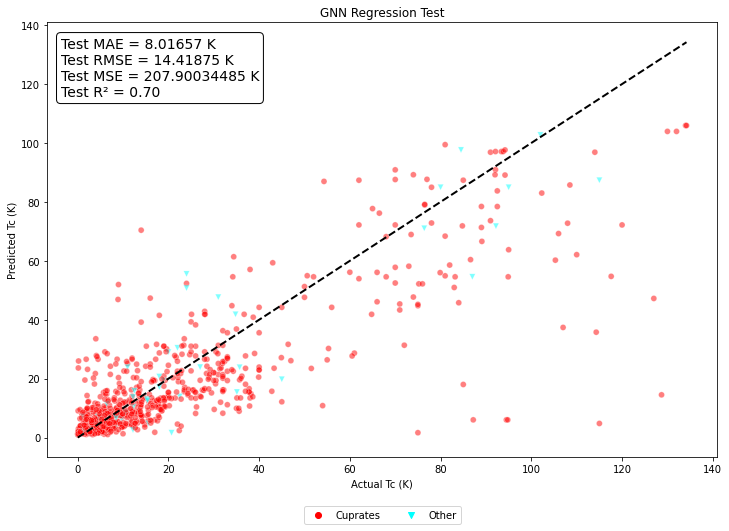

In [13]:
# Extract the category information
category = df[['Category']]

# Move tensors to CPU and convert to NumPy arrays
y_train_array = y_train.cpu().numpy()
y_test_array = y_test.cpu().numpy()

# Ensure predictions are in the correct format
pred_train_y = pred_train_y.cpu().numpy().flatten() if torch.is_tensor(pred_train_y) else np.array(pred_train_y).flatten()
pred_test_y = pred_test_y.cpu().numpy().flatten() if torch.is_tensor(pred_test_y) else np.array(pred_test_y).flatten()

# Convert to DataFrames
y_train_df = pd.DataFrame(y_train_array, columns=['Value'])
y_test_df = pd.DataFrame(y_test_array, columns=['Value'])

# Add predictions to the DataFrames
y_train_df['Predicted'] = pred_train_y
y_test_df['Predicted'] = pred_test_y

# Merge with category data
y_train_df = y_train_df.merge(category, left_index=True, right_index=True)
y_test_df = y_test_df.merge(category, left_index=True, right_index=True)

# Calculate metrics for train data
mae_train = mean_absolute_error(y_train_df['Value'], y_train_df['Predicted'])
rmse_train = mean_squared_error(y_train_df['Value'], y_train_df['Predicted'], squared=False)
mse_train = mean_squared_error(y_train_df['Value'], y_train_df['Predicted'], squared=True)
r2_train = r2_score(y_train_df['Value'], y_train_df['Predicted'])

# Calculate metrics for test data
mae_test = mean_absolute_error(y_test_df['Value'], y_test_df['Predicted'])
rmse_test = mean_squared_error(y_test_df['Value'], y_test_df['Predicted'], squared=False)
mse_test = mean_squared_error(y_test_df['Value'], y_test_df['Predicted'], squared=True)
r2_test = r2_score(y_test_df['Value'], y_test_df['Predicted'])

# Define colors and markers for categories
category_colors = {'Cuprates': 'red', 'Fe-based': 'green', 'Hydrides': 'blue', 'Other': 'cyan'}
category_markers = {'Cuprates': 'o', 'Fe-based': 's', 'Hydrides': '^', 'Other': 'v'}

# Ensure the palette matches the unique categories in the data
unique_categories = y_train_df['Category'].unique()
palette = [category_colors[cat] for cat in unique_categories]

# Plot results for train data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y='Predicted', hue='Category', style='Category',
                palette=palette, markers=category_markers, data=y_train_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Train")
plt.plot([min(y_train_df['Value']), max(y_train_df['Value'])], 
         [min(y_train_df['Value']), max(y_train_df['Value'])], "k--", linewidth=2)
plt.annotate(f"Train MAE = {mae_train:.5f} K\nTrain RMSE = {rmse_train:.5f} K\nTrain MSE = {mse_train:.8f} K\nTrain R² = {r2_train:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

# Ensure the palette matches the unique categories in the test data
unique_categories_test = y_test_df['Category'].unique()
palette_test = [category_colors[cat] for cat in unique_categories_test]

# Plot results for test data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y='Predicted', hue='Category', style='Category',
                palette=palette_test, markers=category_markers, data=y_test_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Test")
plt.plot([min(y_test_df['Value']), max(y_test_df['Value'])], 
         [min(y_test_df['Value']), max(y_test_df['Value'])], "k--", linewidth=2)
plt.annotate(f"Test MAE = {mae_test:.5f} K\nTest RMSE = {rmse_test:.5f} K\nTest MSE = {mse_test:.8f} K\nTest R² = {r2_test:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

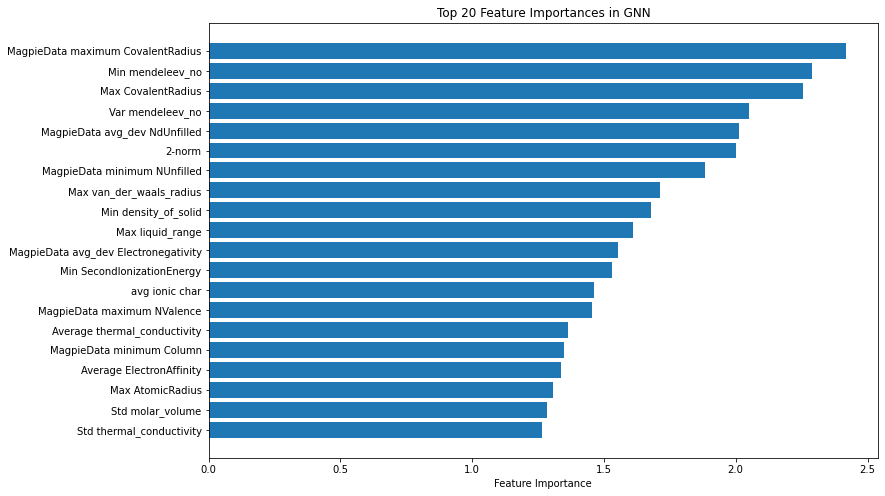

In [14]:
# Function to calculate feature importance
def calculate_feature_importance(model, data, edge_index, device):
    model.eval()
    baseline_pred = model(data, edge_index).cpu().detach().numpy().flatten()
    
    feature_importances = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        data_perturbed = data.clone().cpu().detach().numpy()
        data_perturbed[:, i] = 0  # Zero out the i-th feature
        data_perturbed = torch.tensor(data_perturbed, dtype=torch.float).to(device)
        
        with torch.no_grad():
            perturbed_pred = model(data_perturbed, edge_index).cpu().detach().numpy().flatten()
        
        feature_importances[i] = np.mean(np.abs(baseline_pred - perturbed_pred))
    
    return feature_importances

# Calculate feature importance for train data
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
feature_importances = calculate_feature_importance(model, x_train, edge_index_train, device)

# Get feature names from the original DataFrame
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(norm_train_X.shape[1])]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top 20 features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in GNN')
plt.gca().invert_yaxis()
plt.show()

# Retrain the model with PCA

In [15]:
# Apply PCA
pca = PCA(n_components=244)  # Adjust the number of components as needed
pca_train_X = pca.fit_transform(norm_train_X)
pca_test_X = pca.transform(norm_test_X)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a KNN graph for your training data
k = 10
knn_graph_train = kneighbors_graph(pca_train_X, k, mode='connectivity', include_self=True)
edge_index_train = torch.tensor(np.array(knn_graph_train.nonzero()), dtype=torch.long).to(device)

knn_graph_test = kneighbors_graph(pca_test_X, k, mode='connectivity', include_self=True)
edge_index_test = torch.tensor(np.array(knn_graph_test.nonzero()), dtype=torch.long).to(device)

# Convert your features and labels to tensors
x_train = torch.tensor(pca_train_X, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1).to(device)
x_test = torch.tensor(pca_test_X, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1).to(device)

# Create PyTorch Geometric data objects
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test)

# Create data loaders
train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data], batch_size=1)

/tmp/ipykernel_2619/928362455.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1).to(device)
/tmp/ipykernel_2619/928362455.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1).to(device)


In [17]:
# Initialize the model with the best hyperparameters found
best_params = {'hidden_channels': 123, 'learning_rate': 0.0038180944100928314, 'weight_decay': 6.336991086718003e-05, 'num_layers': 2, 'dropout_rate': 0.04463210774404339, 'conv_type': 'GCN'}
model = GNNModel(num_features=pca_train_X.shape[1], hidden_channels=best_params['hidden_channels'], num_layers=best_params['num_layers'], dropout_rate=best_params['dropout_rate'], conv_type=best_params['conv_type']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = torch.nn.MSELoss()

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
best_model = None
epochs_no_improve = 0

# Training loop with early stopping and more epochs
train_losses = []
val_losses = []

model.train()
for epoch in range(4000):  # Increased number of epochs
    running_train_loss = 0.0
    running_val_loss = 0.0

    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            val_loss = criterion(out, batch.y)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(test_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Save the model
torch.save(model.state_dict(), 'gnn_model.pth')

# Load the model
model = best_model

# Predictions
model.eval()
with torch.no_grad():
    pred_train_y = model(x_train, edge_index_train).cpu().numpy()
    pred_test_y = model(x_test, edge_index_test).cpu().numpy()

Epoch 100, Train Loss: 94.5320, Validation Loss: 199.2735
Early stopping at epoch 115


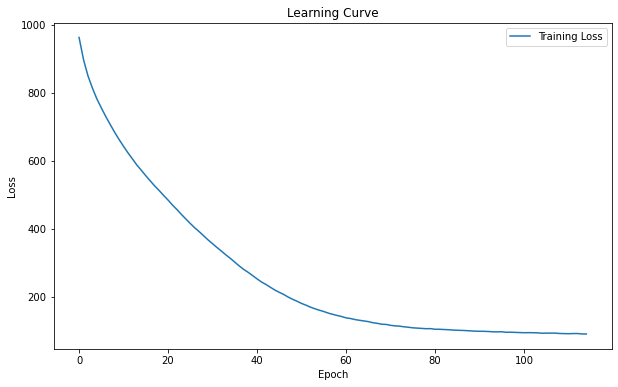

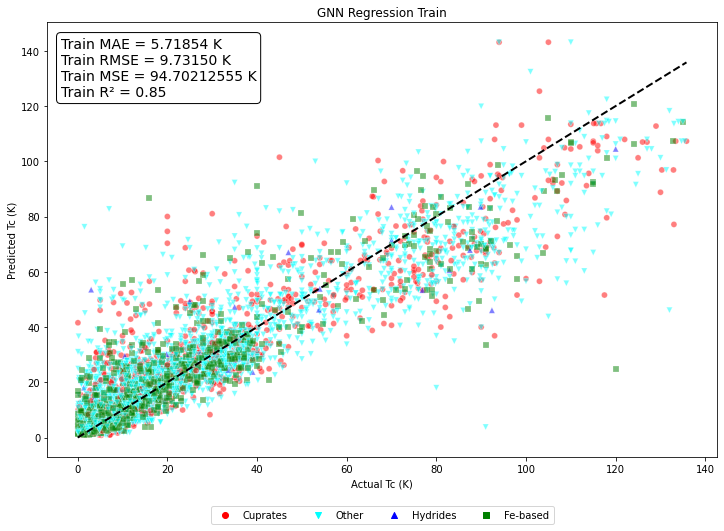

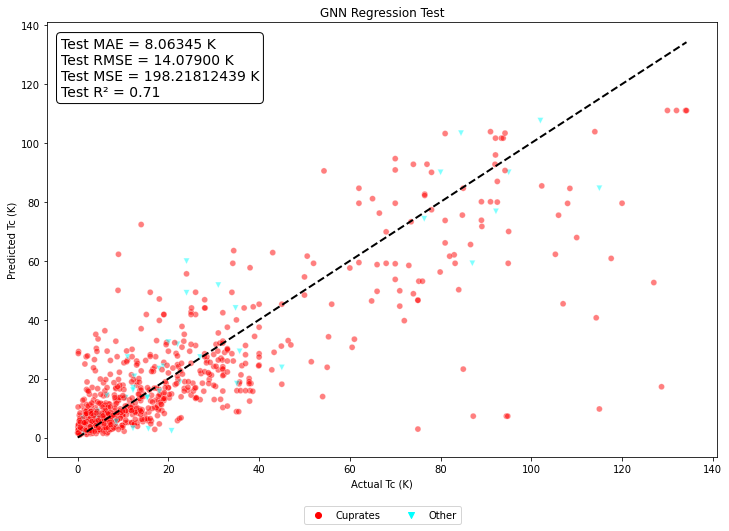

In [18]:
# Extract the category information
category = df[['Category']]

# Move tensors to CPU and convert to NumPy arrays
y_train_array = y_train.cpu().numpy()
y_test_array = y_test.cpu().numpy()

# Ensure predictions are in the correct format
pred_train_y = pred_train_y.cpu().numpy().flatten() if torch.is_tensor(pred_train_y) else np.array(pred_train_y).flatten()
pred_test_y = pred_test_y.cpu().numpy().flatten() if torch.is_tensor(pred_test_y) else np.array(pred_test_y).flatten()

# Convert to DataFrames
y_train_df = pd.DataFrame(y_train_array, columns=['Value'])
y_test_df = pd.DataFrame(y_test_array, columns=['Value'])

# Add predictions to the DataFrames
y_train_df['Predicted'] = pred_train_y
y_test_df['Predicted'] = pred_test_y

# Merge with category data
y_train_df = y_train_df.merge(category, left_index=True, right_index=True)
y_test_df = y_test_df.merge(category, left_index=True, right_index=True)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Calculate metrics for train data
mae_train = mean_absolute_error(y_train_df['Value'], y_train_df['Predicted'])
rmse_train = mean_squared_error(y_train_df['Value'], y_train_df['Predicted'], squared=False)
mse_train = mean_squared_error(y_train_df['Value'], y_train_df['Predicted'], squared=True)
r2_train = r2_score(y_train_df['Value'], y_train_df['Predicted'])

# Calculate metrics for test data
mae_test = mean_absolute_error(y_test_df['Value'], y_test_df['Predicted'])
rmse_test = mean_squared_error(y_test_df['Value'], y_test_df['Predicted'], squared=False)
mse_test = mean_squared_error(y_test_df['Value'], y_test_df['Predicted'], squared=True)
r2_test = r2_score(y_test_df['Value'], y_test_df['Predicted'])

# Define colors and markers for categories
category_colors = {'Cuprates': 'red', 'Fe-based': 'green', 'Hydrides': 'blue', 'Other': 'cyan'}
category_markers = {'Cuprates': 'o', 'Fe-based': 's', 'Hydrides': '^', 'Other': 'v'}

# Ensure the palette matches the unique categories in the data
unique_categories = y_train_df['Category'].unique()
palette = [category_colors[cat] for cat in unique_categories]

# Plot results for train data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y='Predicted', hue='Category', style='Category',
                palette=palette, markers=category_markers, data=y_train_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Train")
plt.plot([min(y_train_df['Value']), max(y_train_df['Value'])], 
         [min(y_train_df['Value']), max(y_train_df['Value'])], "k--", linewidth=2)
plt.annotate(f"Train MAE = {mae_train:.5f} K\nTrain RMSE = {rmse_train:.5f} K\nTrain MSE = {mse_train:.8f} K\nTrain R² = {r2_train:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

# Ensure the palette matches the unique categories in the test data
unique_categories_test = y_test_df['Category'].unique()
palette_test = [category_colors[cat] for cat in unique_categories_test]

# Plot results for test data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y='Predicted', hue='Category', style='Category',
                palette=palette_test, markers=category_markers, data=y_test_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Test")
plt.plot([min(y_test_df['Value']), max(y_test_df['Value'])], 
         [min(y_test_df['Value']), max(y_test_df['Value'])], "k--", linewidth=2)
plt.annotate(f"Test MAE = {mae_test:.5f} K\nTest RMSE = {rmse_test:.5f} K\nTest MSE = {mse_test:.8f} K\nTest R² = {r2_test:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

# Retrain the model after filtering features based on feature importance (after PCA)

Number of Features: 5, Test RMSE: 22.3308
Number of Features: 6, Test RMSE: 19.9859
Number of Features: 7, Test RMSE: 16.3159
Number of Features: 8, Test RMSE: 16.2139
Number of Features: 9, Test RMSE: 15.7142
Number of Features: 10, Test RMSE: 15.7694
Number of Features: 11, Test RMSE: 15.7672
Number of Features: 12, Test RMSE: 15.8892
Number of Features: 13, Test RMSE: 15.8170
Number of Features: 14, Test RMSE: 15.7523
Number of Features: 15, Test RMSE: 14.8098
Number of Features: 16, Test RMSE: 15.0058
Number of Features: 17, Test RMSE: 14.6878
Number of Features: 18, Test RMSE: 22.2008
Number of Features: 19, Test RMSE: 14.7884
Number of Features: 20, Test RMSE: 14.8751
Number of Features: 21, Test RMSE: 22.8455
Number of Features: 22, Test RMSE: 15.1205
Number of Features: 23, Test RMSE: 15.1644
Number of Features: 24, Test RMSE: 15.6041
Number of Features: 25, Test RMSE: 23.3900
Number of Features: 26, Test RMSE: 21.1931
Number of Features: 27, Test RMSE: 15.1002
Number of Featur

Number of Features: 194, Test RMSE: 13.8963
Number of Features: 195, Test RMSE: 14.4108
Number of Features: 196, Test RMSE: 13.6969
Number of Features: 197, Test RMSE: 14.2867
Number of Features: 198, Test RMSE: 14.4806
Number of Features: 199, Test RMSE: 20.7005
Number of Features: 200, Test RMSE: 20.0904
Number of Features: 201, Test RMSE: 14.0056
Number of Features: 202, Test RMSE: 14.0477
Number of Features: 203, Test RMSE: 13.8896
Number of Features: 204, Test RMSE: 14.3191
Number of Features: 205, Test RMSE: 14.2229
Number of Features: 206, Test RMSE: 20.7434
Number of Features: 207, Test RMSE: 19.5164
Number of Features: 208, Test RMSE: 19.6151
Number of Features: 209, Test RMSE: 14.0532
Number of Features: 210, Test RMSE: 14.1198
Number of Features: 211, Test RMSE: 20.4104
Number of Features: 212, Test RMSE: 14.1337
Number of Features: 213, Test RMSE: 14.1547
Number of Features: 214, Test RMSE: 14.4472
Number of Features: 215, Test RMSE: 20.0639
Number of Features: 216, Test RM

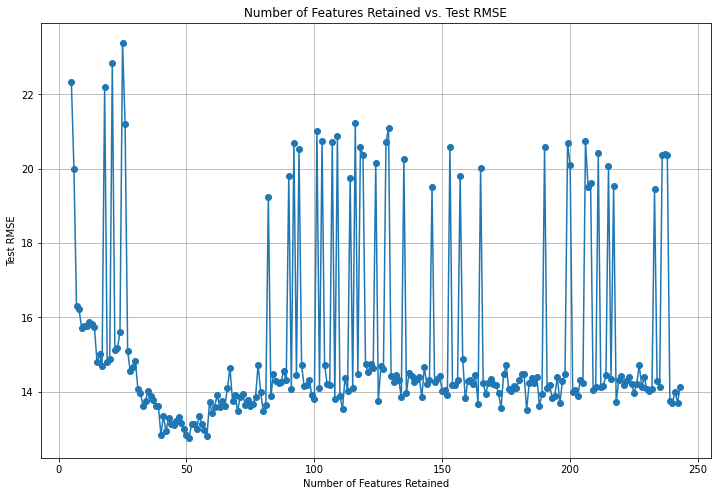

In [19]:
# Function to calculate feature importance
def calculate_feature_importance(model, data, edge_index, device):
    model.eval()
    baseline_pred = model(data, edge_index).cpu().detach().numpy().flatten()
    
    feature_importances = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        data_perturbed = data.clone().cpu().detach().numpy()
        data_perturbed[:, i] = 0  # Zero out the i-th feature
        data_perturbed = torch.tensor(data_perturbed, dtype=torch.float).to(device)
        
        with torch.no_grad():
            perturbed_pred = model(data_perturbed, edge_index).cpu().detach().numpy().flatten()
        
        feature_importances[i] = np.mean(np.abs(baseline_pred - perturbed_pred))
    
    return feature_importances

def retrain_and_evaluate(model, num_top_features, norm_train_X, norm_test_X, y_train, y_test, edge_index_train, edge_index_test, device, best_params):
    top_features = filtered_feature_importance_df['Feature'].values[:num_top_features]
    norm_train_X_top = norm_train_X[:, feature_importance_df['Feature'].isin(top_features)]
    norm_test_X_top = norm_test_X[:, feature_importance_df['Feature'].isin(top_features)]
    
    # Convert Dataframe to Numpy array if needed
    norm_train_X_top = norm_train_X_top.to_numpy() if hasattr(norm_train_X_top, 'to_numpy') else norm_train_X_top
    norm_test_X_top = norm_test_X_top.to_numpy() if hasattr(norm_test_X_top, 'to_numpy') else norm_test_X_top
    
    # Create a KNN graph for your training data with the selected features
    k = 10
    knn_graph_train = kneighbors_graph(norm_train_X_top, k, mode='connectivity', include_self=True)
    edge_index_train = torch.tensor(np.array(knn_graph_train.nonzero()), dtype=torch.long).to(device)
    
    knn_graph_test = kneighbors_graph(norm_test_X_top, k, mode='connectivity', include_self=True)
    edge_index_test = torch.tensor(np.array(knn_graph_test.nonzero()), dtype=torch.long).to(device)
    
    # Convert your features and labels to tensors
    x_train = torch.tensor(norm_train_X_top, dtype=torch.float).to(device)
    x_test = torch.tensor(norm_test_X_top, dtype=torch.float).to(device)
    
    # Create PyTorch Geometric data objects
    train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train)
    test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test)
    
    # Create data loaders
    train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=1)
    
    # Retrain the model with the filtered features using the best hyperparameters found
    model = GNNModel(num_features=norm_train_X_top.shape[1], hidden_channels=best_params['hidden_channels'], num_layers=best_params['num_layers'], dropout_rate=best_params['dropout_rate'], conv_type=best_params['conv_type']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = torch.nn.MSELoss()
    
    # Training loop with early stopping
    patience = 10
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    
    model.train()
    for epoch in range(4000):
        running_train_loss = 0.0
        running_val_loss = 0.0
        
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        train_loss = running_train_loss / len(train_loader)
        
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index)
                val_loss = criterion(out, batch.y)
                running_val_loss += val_loss.item()
        
        val_loss = running_val_loss / len(test_loader)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                break
    
    # Evaluate the model
    best_model.eval()
    with torch.no_grad():
        pred_train_y = best_model(x_train, edge_index_train).cpu().numpy()
        pred_test_y = best_model(x_test, edge_index_test).cpu().numpy()
    
    # Calculate metrics
    mae_train = mean_absolute_error(y_train.cpu().numpy(), pred_train_y)
    rmse_train = mean_squared_error(y_train.cpu().numpy(), pred_train_y, squared=False)
    mse_train = mean_squared_error(y_train.cpu().numpy(), pred_train_y, squared=True)
    r2_train = r2_score(y_train.cpu().numpy(), pred_train_y)
    
    mae_test = mean_absolute_error(y_test.cpu().numpy(), pred_test_y)
    rmse_test = mean_squared_error(y_test.cpu().numpy(), pred_test_y, squared=False)
    mse_test = mean_squared_error(y_test.cpu().numpy(), pred_test_y, squared=True)
    r2_test = r2_score(y_test.cpu().numpy(), pred_test_y)
    
    result = {
        'num_features': num_top_features,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'mse_train': mse_train,
        'r2_train': r2_train,
        'mae_test': mae_test,
        'rmse_test': rmse_test,
        'mse_test': mse_test,
        'r2_test': r2_test,
        'pred_train_y': pred_train_y,
        'pred_test_y': pred_test_y
    }
    
    return result


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate feature importance for train data
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
feature_importances = calculate_feature_importance(model, x_train, edge_index_train, device)

# Get feature names from the original DataFrame
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(norm_train_X.shape[1])]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Filter out features with zero importance and select top 150 features
filtered_feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]
filtered_feature_importance_df = filtered_feature_importance_df.sort_values(by='Importance', ascending=False).head(150)

# Update the loop to store and print the results correctly
evaluation_results = []

for num_features in range(5, 244):
    result = retrain_and_evaluate(model, num_features, norm_train_X, norm_test_X, y_train, y_test, edge_index_train, edge_index_test, device, best_params)
    evaluation_results.append(result)
    print(f'Number of Features: {num_features}, Test RMSE: {result["rmse_test"]:.4f}')

# Plot the number of features retained vs. test RMSE
num_features_retained = [result['num_features'] for result in evaluation_results]
test_rmse_list = [result['rmse_test'] for result in evaluation_results]

plt.figure(figsize=(12, 8))
plt.plot(num_features_retained, test_rmse_list, marker='o')
plt.xlabel('Number of Features Retained')
plt.ylabel('Test RMSE')
plt.title('Number of Features Retained vs. Test RMSE')
plt.grid()
plt.show()

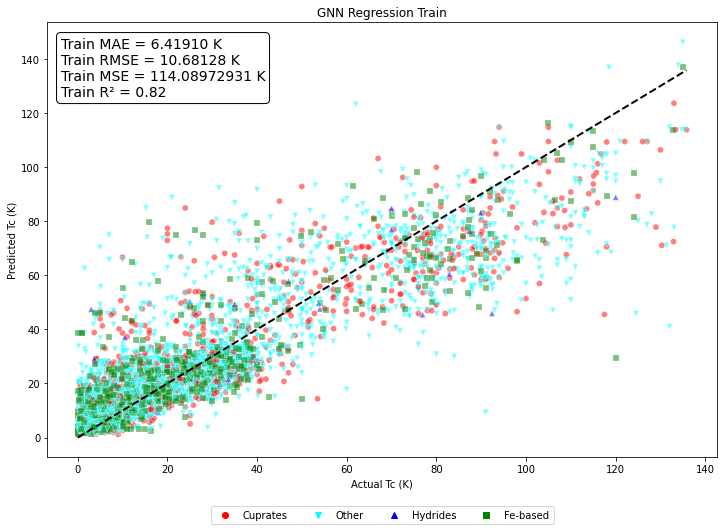

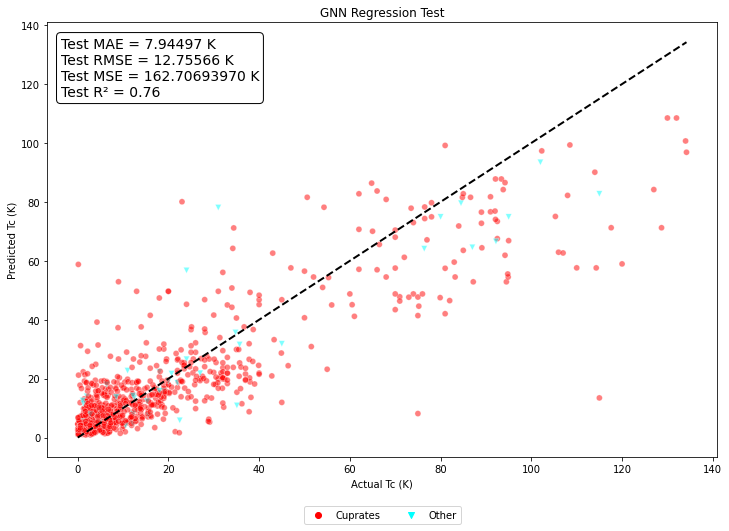

In [20]:
# Find the model with the lowest RMSE on the test data
best_result = min(evaluation_results, key=lambda x: x['rmse_test'])

# Extract the category information
category = df[['Category']]

# Move tensors to CPU and convert to NumPy arrays
y_train_array = y_train.cpu().numpy()
y_test_array = y_test.cpu().numpy()

# Ensure predictions are in the correct format
pred_train_y = np.array(best_result['pred_train_y']).flatten()
pred_test_y = np.array(best_result['pred_test_y']).flatten()

# Convert to DataFrames
y_train_df = pd.DataFrame(y_train_array, columns=['Value'])
y_test_df = pd.DataFrame(y_test_array, columns=['Value'])

# Merge with category data
y_train_df = y_train_df.merge(category, left_index=True, right_index=True)
y_test_df = y_test_df.merge(category, left_index=True, right_index=True)

# Define colors and markers for categories
category_colors = {'Cuprates': 'red', 'Fe-based': 'green', 'Hydrides': 'blue', 'Other': 'cyan'}
category_markers = {'Cuprates': 'o', 'Fe-based': 's', 'Hydrides': '^', 'Other': 'v'}

# Ensure the palette matches the unique categories in the data
unique_categories = y_train_df['Category'].unique()
palette = [category_colors[cat] for cat in unique_categories]

# Plot results for train data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y=pred_train_y, hue='Category', style='Category',
                palette=palette, markers=category_markers, data=y_train_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Train")
plt.plot([min(y_train_array), max(y_train_array)], 
         [min(y_train_array), max(y_train_array)], "k--", linewidth=2)
plt.annotate(f"Train MAE = {best_result['mae_train']:.5f} K\nTrain RMSE = {best_result['rmse_train']:.5f} K\nTrain MSE = {best_result['mse_train']:.8f} K\nTrain R² = {best_result['r2_train']:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

# Ensure the palette matches the unique categories in the test data
unique_categories_test = y_test_df['Category'].unique()
palette_test = [category_colors[cat] for cat in unique_categories_test]

# Plot results for test data using seaborn
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='Value', y=pred_test_y, hue='Category', style='Category',
                palette=palette_test, markers=category_markers, data=y_test_df, alpha=0.5)
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Test")
plt.plot([min(y_test_array), max(y_test_array)], 
         [min(y_test_array), max(y_test_array)], "k--", linewidth=2)
plt.annotate(f"Test MAE = {best_result['mae_test']:.5f} K\nTest RMSE = {best_result['rmse_test']:.5f} K\nTest MSE = {best_result['mse_test']:.8f} K\nTest R² = {best_result['r2_test']:.2f}", 
             (0.02, 0.83), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

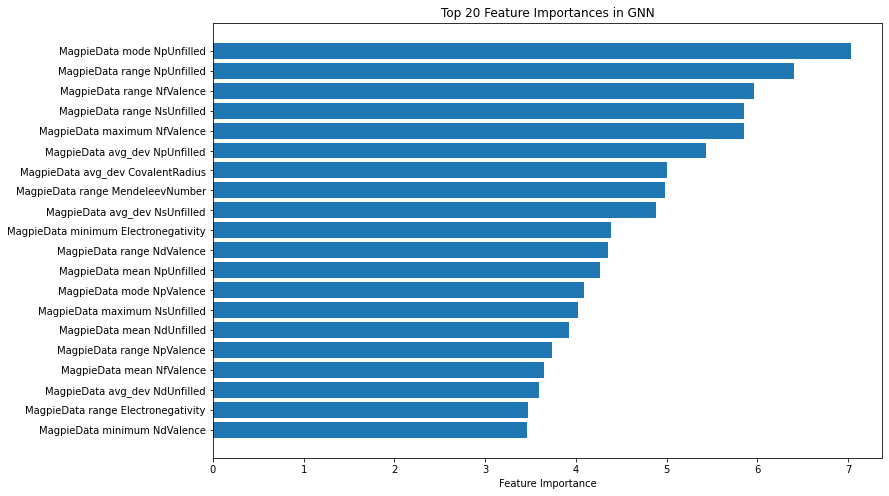

In [21]:
# Calculate feature importance for train data
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
feature_importances = calculate_feature_importance(model, x_train, edge_index_train, device)

# Get feature names from the original DataFrame
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(norm_train_X.shape[1])]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top 20 features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in GNN')
plt.gca().invert_yaxis()
plt.show()